# Dask Data structures

Dask offers several pythonic data structures to handle and operate with larger-than-memory data in a distributed system.
- `dask.bag`: distributed generic python list. The Dask equivalent to a PySpark RDD
- `dask.array`: distributed numpy arrays
- `dask.dataframe`: distributed pandas dataframes

All the high-level data structure APIs are optimized to exploit the DAG optimization features of the Dask scheduler, and thus rely on lazy computation.

## Start the Dask cluster

In [1]:
from dask.distributed import Client
 
# use the provided master
client = Client('dask-scheduler:8786')
    
# print the status of the client    
client

<Client: 'tcp://172.18.0.2:8786' processes=3 threads=3, memory=1.43 GiB>

## Dask Bag

Bags are very powerful and flexible data structures.
The Dask Bag offers essentially the same degree of flexibility as the RDD in PySpark.
They are parallelized general collections of objects, like Python’s built-in `list`, and can therefore hold any Python objects, whether they are custom classes or built-in types. 
This makes it possible to contain very complicated data structures, like raw text or nested JSON data, and navigate them with ease.

For these reasons, Dask bags are often used to parallelize simple computations on unstructured or semi-structured data such as text data, log files, JSON records, or user-defined Python objects, using MapReduce-like approaches to load, inspect, filter, and process arbitrary datasets (structured or unstructured).

Dask Bag implements operations like `map`, `filter`, `groupby`, and aggregations on collections of Python objects.
It does this in parallel using Python iterators, similar to a parallel version of itertools.

Once a first stage of data preparation is completed using Dask Bag, it is quite common to reduce and convert the data into more suitable data structures, such as Dask Arrays or Dask DataFrames, which will be covered later on.

### Create and Take from a Bag

We can create a `Bag` from a Python sequence, from files, or from data on cloud storage such as Amazon AWS S3, and more.
For a comprehensive overview of the ways to access remote data from DFS, S3, and others, please refer to the official documentation at the [link](https://docs.dask.org/en/stable/how-to/connect-to-remote-data.html).

We can also create a Bag from a function declared as `delayed`.
This way, we can generate data from a distributed application and then access the data with the Bag API before computing a result.

The data is partitioned into blocks, usually with multiple items per block, depending on the datasets, the cluster resources, and our choice of the `npartitions` parameter.

Let's start by creating some simple data from a Python list.
Clearly, as Python is a dynamically typed language, this can be a simple array of integers or an arbitrary collection of multiple data types (numbers, strings, objects, etc.).

In [2]:
import dask.bag as db

# create a Dask Bag from a Python sequence
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# create a Dask Bag from the sequence with 4 partitions
b = db.from_sequence(data, npartitions=4)

As previously mentioned, Dask data structures embody the lazy programming paradigm.
The data is thus not yet stored on the cluster, as we have not performed an operation such as `compute`.

In general, we don't want to retrieve the entire data stored on the cluster, but we might want to inspect a few elements.
We can do that with the `take(n_elements)` method.
The returned data will be a tuple containing the first `n_elements` of the Bag.

In [3]:
# retrieve the first 3 elements of the Bag
b.take(3)

(1, 2, 3)

Data can be extracted from text files by providing a list of all files or using the `*` wildcard.

By default, the resulting Bag will have one item per line and one file per partition (so be careful when partitioning the data).

A nice feature of Dask when reading text files is that it handles standard compression libraries (like gzip, bz2, xz) automatically. The compression can be inferred from the file name extension or specified using the `compression='gzip'` keyword argument.

For instance, we can load a number of compressed files from a local folder into a Bag:

In [4]:
# list the files provided
! ls datasets/accounts_json/. 

accounts.00.json.gz  accounts.17.json.gz  accounts.34.json.gz
accounts.01.json.gz  accounts.18.json.gz  accounts.35.json.gz
accounts.02.json.gz  accounts.19.json.gz  accounts.36.json.gz
accounts.03.json.gz  accounts.20.json.gz  accounts.37.json.gz
accounts.04.json.gz  accounts.21.json.gz  accounts.38.json.gz
accounts.05.json.gz  accounts.22.json.gz  accounts.39.json.gz
accounts.06.json.gz  accounts.23.json.gz  accounts.40.json.gz
accounts.07.json.gz  accounts.24.json.gz  accounts.41.json.gz
accounts.08.json.gz  accounts.25.json.gz  accounts.42.json.gz
accounts.09.json.gz  accounts.26.json.gz  accounts.43.json.gz
accounts.10.json.gz  accounts.27.json.gz  accounts.44.json.gz
accounts.11.json.gz  accounts.28.json.gz  accounts.45.json.gz
accounts.12.json.gz  accounts.29.json.gz  accounts.46.json.gz
accounts.13.json.gz  accounts.30.json.gz  accounts.47.json.gz
accounts.14.json.gz  accounts.31.json.gz  accounts.48.json.gz
accounts.15.json.gz  accounts.32.json.gz  accounts.49.json.gz
accounts

In [5]:
import os

# read text files from the specified directory and use gzip compression
b = db.read_text(os.path.join('datasets','accounts_json','accounts.*.json.gz'),
                 files_per_partition=4)

# take the first element from the bag
example = b.take(1)

# print the type of the example variable
print(type(example))
print()

# print the example variable
print(example)

<class 'tuple'>

('{"id": 0, "name": "Dan", "transactions": [{"transaction-id": 14, "amount": 4526}, {"transaction-id": 2814, "amount": 4412}, {"transaction-id": 4918, "amount": 4301}, {"transaction-id": 12573, "amount": 4215}, {"transaction-id": 14264, "amount": 4428}, {"transaction-id": 15537, "amount": 4317}, {"transaction-id": 18212, "amount": 4644}, {"transaction-id": 21465, "amount": 4351}, {"transaction-id": 24422, "amount": 4292}, {"transaction-id": 29525, "amount": 4297}, {"transaction-id": 36043, "amount": 4232}, {"transaction-id": 41620, "amount": 4405}, {"transaction-id": 42443, "amount": 4356}, {"transaction-id": 43028, "amount": 4243}, {"transaction-id": 46824, "amount": 4320}, {"transaction-id": 48087, "amount": 4501}, {"transaction-id": 51930, "amount": 4345}, {"transaction-id": 52633, "amount": 4214}, {"transaction-id": 57717, "amount": 4388}, {"transaction-id": 60042, "amount": 4419}, {"transaction-id": 63538, "amount": 4434}, {"transaction-id": 70414, "amount": 4357}

`Bag` objects support standard functional APIs, including `map`, `filter`, `groupby`, and more.

Operations on `Bag` objects create new bags, allowing us to chain multiple operations together to manipulate the data until we obtain the desired result.

To trigger the execution, we can use the `.compute()` method, similar to any `delayed` object we've seen before.

Since a bag is inherently a delayed object, there is no need to explicitly specify that the functions we apply to the dataset are further delayed.

In [6]:
# function to check if a number is even
def is_even(n):
    return n % 2 == 0

# create a bag from a sequence of numbers
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# filter the numbers to keep only the even ones
# then, map a lambda function to square each even number
c = b.filter(is_even).map(lambda x: x ** 2)

# print the resulting bag
c

dask.bag<lambda, npartitions=10>

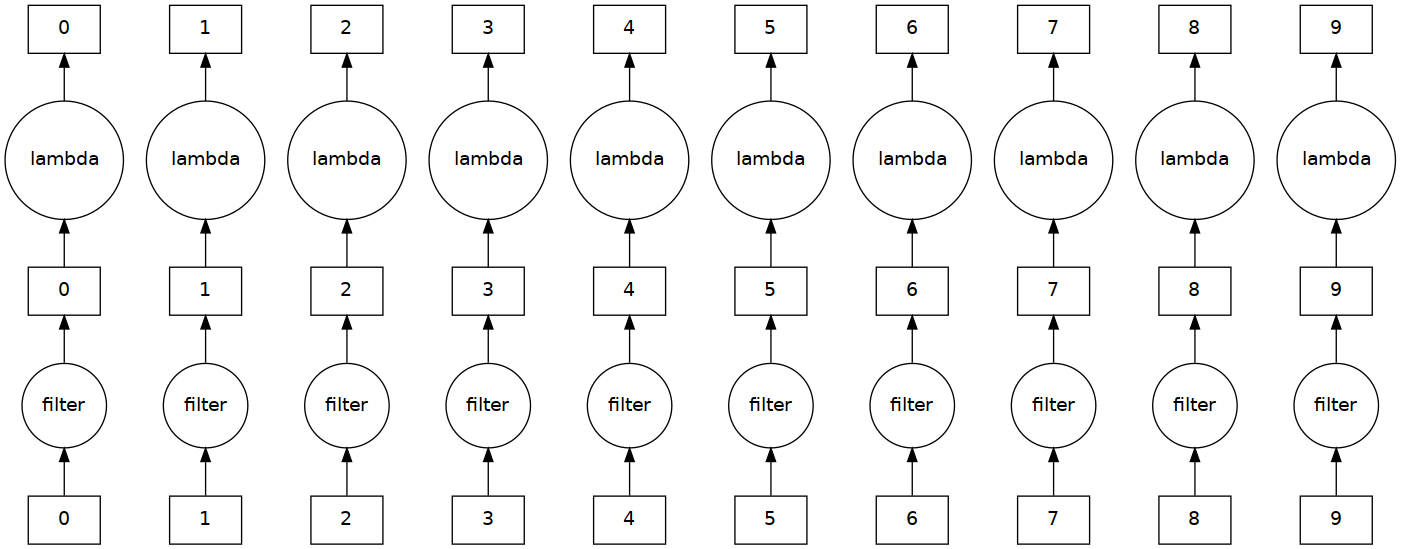

In [7]:
# visualize the computational graph
c.visualize()

In [8]:
# compute the results
c.compute()

[4, 16, 36, 64, 100]

Please note that one of the crucial parameters when optimizing a computing task on a cluster is to ensure the effective utilization of available computing resources. This involves rewriting the computational task to be distributed efficiently and optimizing the number of partitions used to store data and perform map-like data transformations.

Consider the following scenarios:
- Having only one partition with 100 available CPUs would be inefficient as there would be no parallelization at all.
- Having 10,000 tiny partitions with 3 available CPUs each would likely be inefficient due to the overhead of starting and stopping computation on each individual tiny partition.
- The optimal number of partitions depends on factors such as the amount of shuffling required (e.g., for `groupby` operations). For example, having 100 partitions with 20 available CPUs might be more efficient than having 25 partitions, but the optimal choice will depend on your specific workload.

Determining the optimal partitioning strategy is a task that requires optimization and educated guesses based on the available processing units in your cluster. There is no one-size-fits-all answer to this question.

Ultimately, you will need to experiment and fine-tune your partitioning strategy based on your specific workload and cluster characteristics.

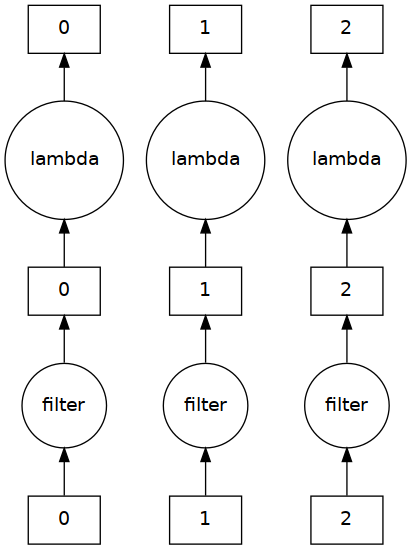

In [9]:
# create a new bag with the same data, but a different number of partitions
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=3)

# filter the numbers to keep only the even ones
# then, map a lambda function to square each even number
c = b.filter(is_even).map(lambda x: x ** 2)

# visualize the computation graph
c.visualize()

In [10]:
# compute the results
c.compute()

[4, 16, 36, 64, 100]

## Exercise 1 - Open and preprocess JSON data

We'll start with a dummy dataset of gzipped JSON data in your data directory. This dataset is analogous to what you might collect from a document store database (e.g., MongoDB) or by scraping a website using the dedicated API.

Each line of each document is a JSON-encoded dictionary with the following keys:

* `id`: Unique identifier of the customer
* `name`: Name of the customer
* `transactions`: A list of key-value pairs in the form of `transaction-id` and `amount` pairs (one for each transaction made by the customer in that file)

1. **Create a Bag reading out the dataset from the text files**
2. **Map the `json.loads` function on each message to extract the data in the form of python dictionaries**

In [11]:
# 1. create a Dask Bag `db_lines` from the files
db_lines = db.read_text(os.path.join('datasets','accounts_json','accounts.*.json.gz'),
                        files_per_partition=4)
db_lines.take(1)

('{"id": 0, "name": "Dan", "transactions": [{"transaction-id": 14, "amount": 4526}, {"transaction-id": 2814, "amount": 4412}, {"transaction-id": 4918, "amount": 4301}, {"transaction-id": 12573, "amount": 4215}, {"transaction-id": 14264, "amount": 4428}, {"transaction-id": 15537, "amount": 4317}, {"transaction-id": 18212, "amount": 4644}, {"transaction-id": 21465, "amount": 4351}, {"transaction-id": 24422, "amount": 4292}, {"transaction-id": 29525, "amount": 4297}, {"transaction-id": 36043, "amount": 4232}, {"transaction-id": 41620, "amount": 4405}, {"transaction-id": 42443, "amount": 4356}, {"transaction-id": 43028, "amount": 4243}, {"transaction-id": 46824, "amount": 4320}, {"transaction-id": 48087, "amount": 4501}, {"transaction-id": 51930, "amount": 4345}, {"transaction-id": 52633, "amount": 4214}, {"transaction-id": 57717, "amount": 4388}, {"transaction-id": 60042, "amount": 4419}, {"transaction-id": 63538, "amount": 4434}, {"transaction-id": 70414, "amount": 4357}, {"transaction-i

In [12]:
import json
from pprint import pprint

In [13]:
# 2. read the data from the JSON format into a `db_js` bag
db_js = db_lines.map(json.loads) # or .map(lambda x: json.loads(x))
pprint(db_js.take(1))

({'id': 0,
  'name': 'Dan',
  'transactions': [{'amount': 4526, 'transaction-id': 14},
                   {'amount': 4412, 'transaction-id': 2814},
                   {'amount': 4301, 'transaction-id': 4918},
                   {'amount': 4215, 'transaction-id': 12573},
                   {'amount': 4428, 'transaction-id': 14264},
                   {'amount': 4317, 'transaction-id': 15537},
                   {'amount': 4644, 'transaction-id': 18212},
                   {'amount': 4351, 'transaction-id': 21465},
                   {'amount': 4292, 'transaction-id': 24422},
                   {'amount': 4297, 'transaction-id': 29525},
                   {'amount': 4232, 'transaction-id': 36043},
                   {'amount': 4405, 'transaction-id': 41620},
                   {'amount': 4356, 'transaction-id': 42443},
                   {'amount': 4243, 'transaction-id': 43028},
                   {'amount': 4320, 'transaction-id': 46824},
                   {'amount': 4501, 'transactio

Once the JSON data is mapped into the appropriate Python objects (dictionaries, lists, etc.), we can perform specific operations by creating small Python functions to run on our data.

The most basic operations we can perform on a Dask Bag are as follows:
- `map`: Apply a function to each element.
- `filter`: Retain only the elements that satisfy a given function.
- `pluck`: Select a specific nested field, such as `element[field]` from a Python dictionary.
- `flatten`: Unfold the dictionary into a list-like object.

These operations provide a foundation for manipulating and transforming the data within a Dask Bag.

**1. compute the average number of transactions for each entry of a user named "Alice"**

In [14]:
# retain only the records from users named "Alice"
db_js.filter(lambda x: x["name"] == "Alice").take(3)

({'id': 32,
  'name': 'Alice',
  'transactions': [{'transaction-id': 91, 'amount': 639},
   {'transaction-id': 1961, 'amount': 616},
   {'transaction-id': 3335, 'amount': 625},
   {'transaction-id': 4887, 'amount': 628},
   {'transaction-id': 5255, 'amount': 619},
   {'transaction-id': 6981, 'amount': 590},
   {'transaction-id': 7348, 'amount': 629},
   {'transaction-id': 9342, 'amount': 625},
   {'transaction-id': 9653, 'amount': 623},
   {'transaction-id': 10116, 'amount': 626},
   {'transaction-id': 10185, 'amount': 588},
   {'transaction-id': 10454, 'amount': 603},
   {'transaction-id': 10811, 'amount': 628},
   {'transaction-id': 11162, 'amount': 618},
   {'transaction-id': 12914, 'amount': 647},
   {'transaction-id': 12995, 'amount': 604},
   {'transaction-id': 14087, 'amount': 622},
   {'transaction-id': 15828, 'amount': 622},
   {'transaction-id': 16813, 'amount': 637},
   {'transaction-id': 19480, 'amount': 619},
   {'transaction-id': 21538, 'amount': 598},
   {'transaction-id

In [15]:
# retain only the records from users named "Alice"
# AND count the total number of transactions for each entry in the dataset 

# function reformatting each record with the new information
def count_transactions(d):
    return {"name": d["name"], "count": len(d["transactions"])}

db_js.filter(lambda x: x["name"] == "Alice").map(count_transactions).take(3)

({'name': 'Alice', 'count': 122},
 {'name': 'Alice', 'count': 160},
 {'name': 'Alice', 'count': 398})

In [16]:
# retain only the records from users named "Alice"
# AND count the total number of transactions (as 'count') for each entry in the dataset 
# AND return only the 'count' values
db_js.filter(lambda x: x["name"] == "Alice").map(count_transactions).pluck("count").take(3) # or .pluck("transactions").map(len)

(122, 160, 398)

In [18]:
# retain only the records from users named "Alice"
# AND count the total number of transactions (as 'count') for each entry in the dataset 
# AND return only the 'count' values
# AND compute the average of the counts
db_js.filter(lambda x: x["name"] == "Alice").map(count_transactions).pluck("count").mean().compute() #.map(lambda x: sum(x)/len(x))

215.52896551724137

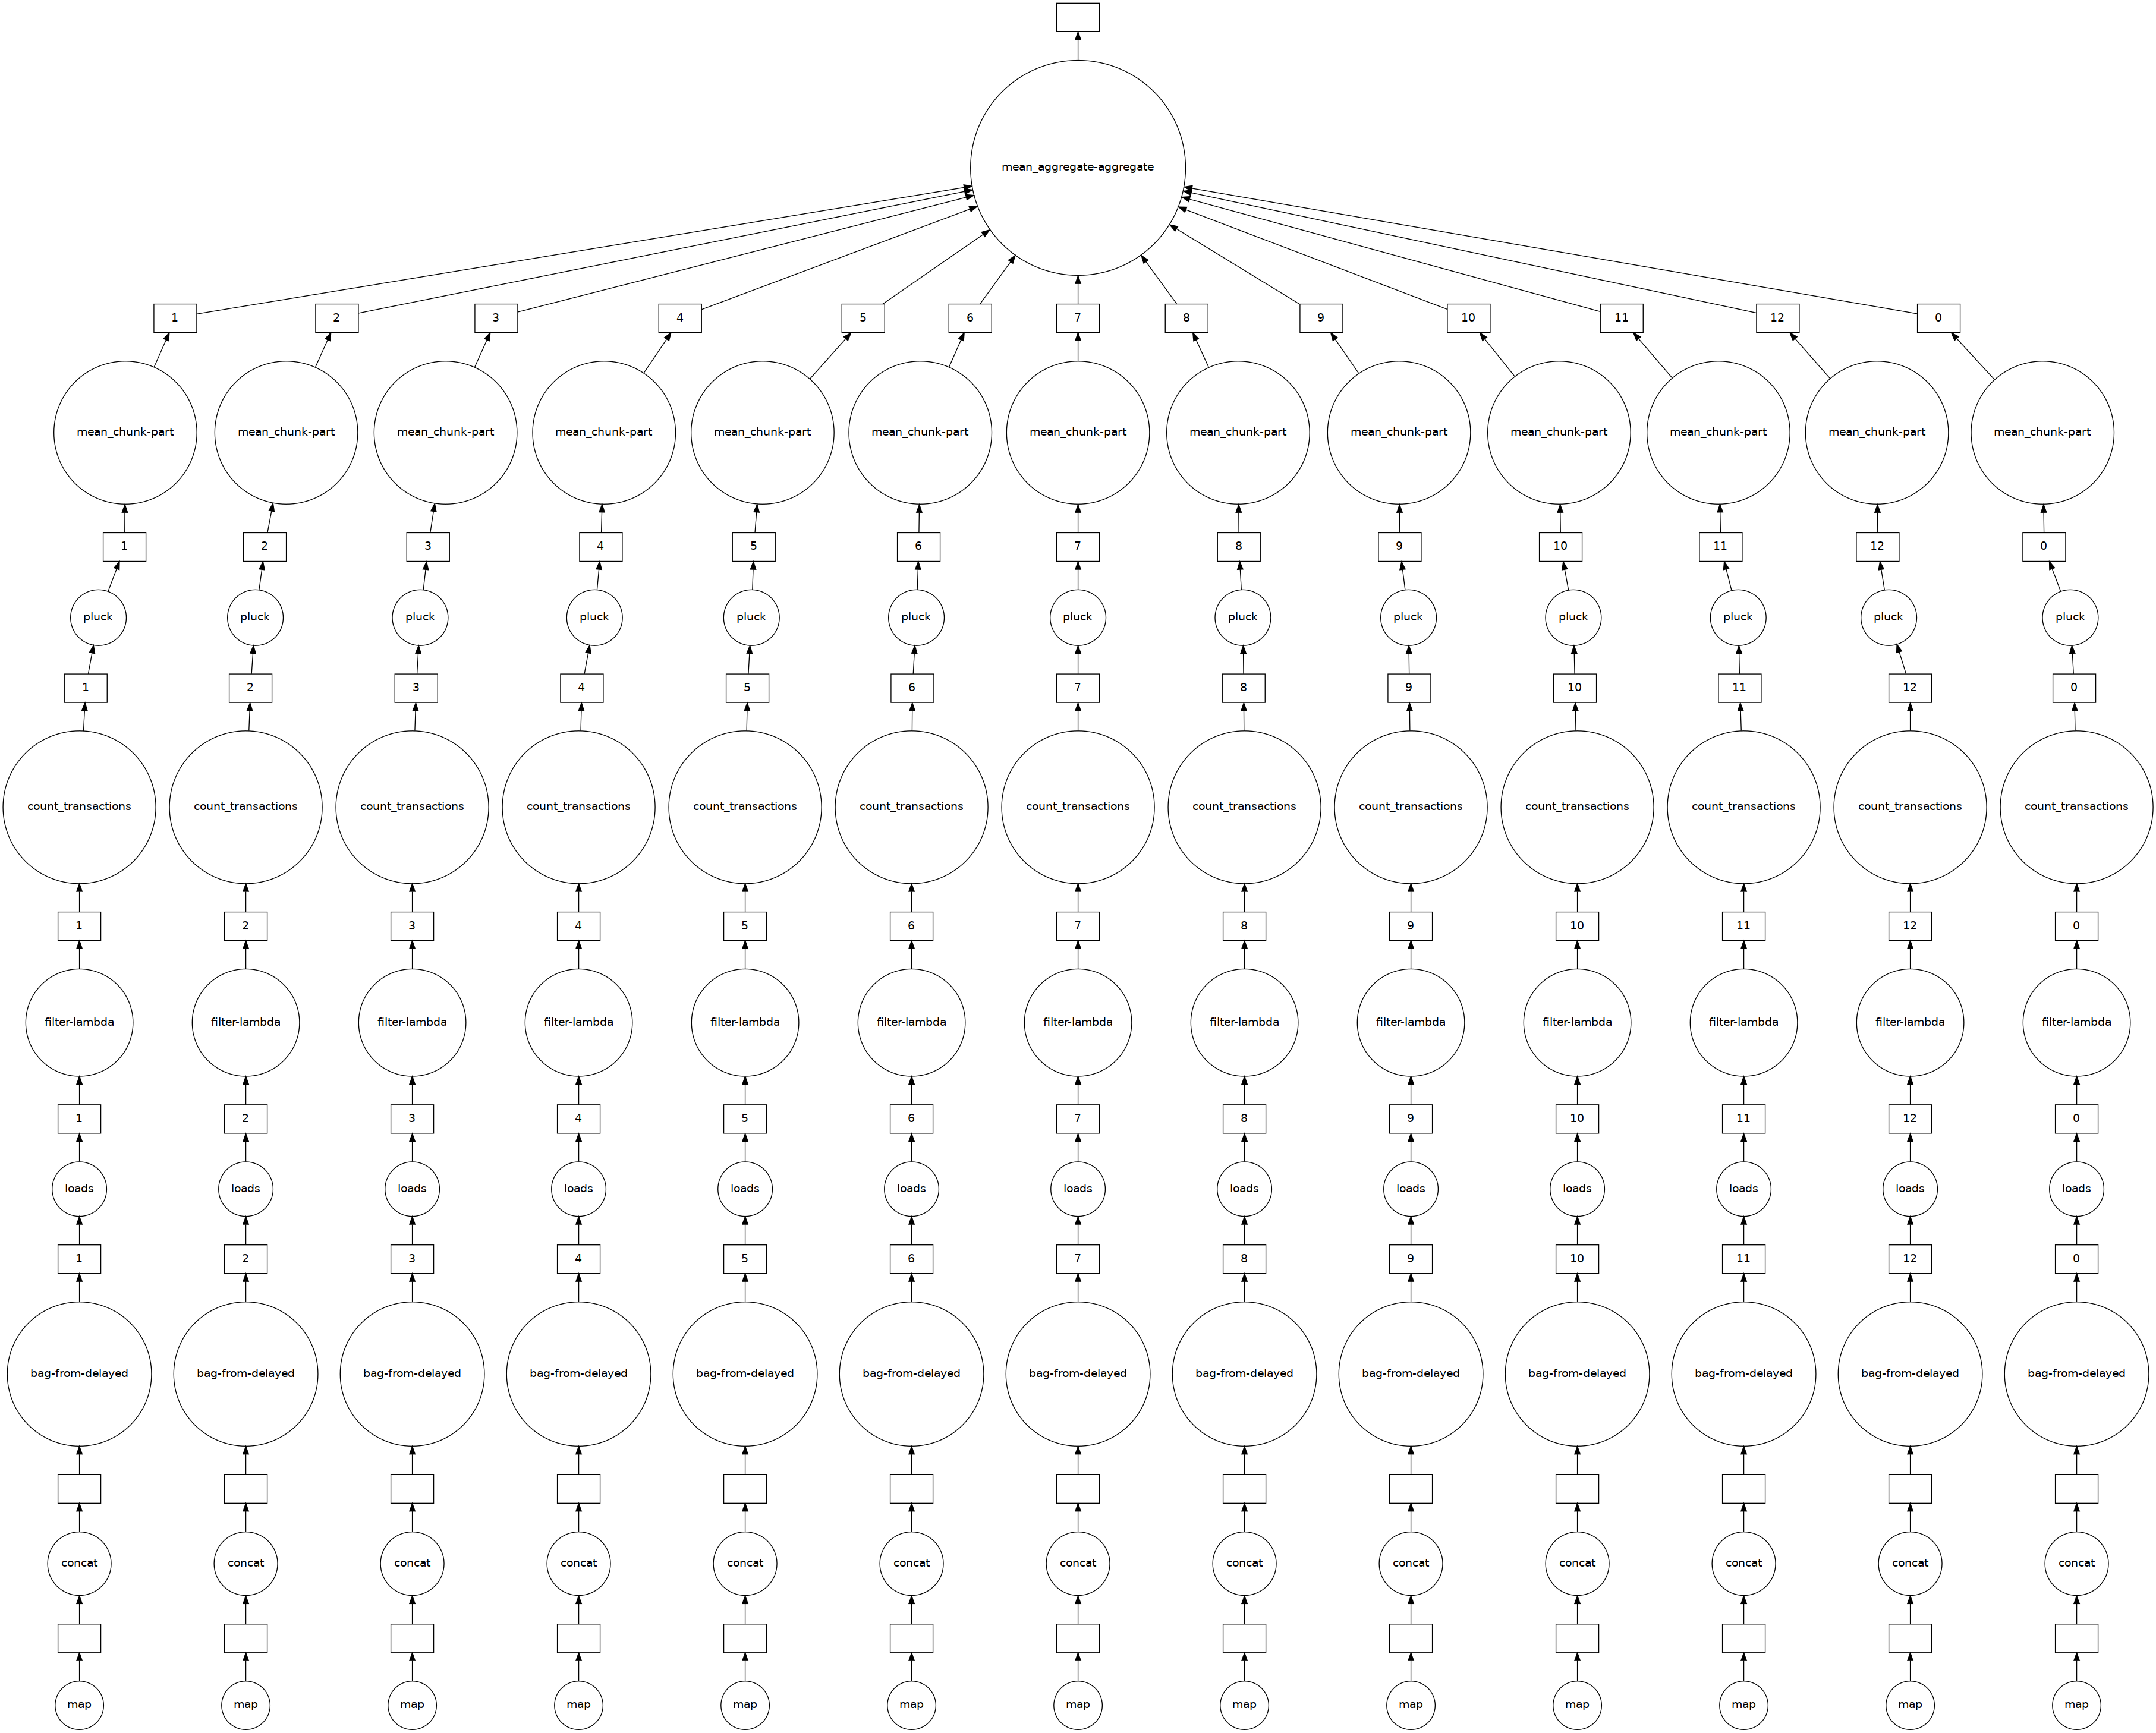

In [20]:
# visualize the graph of the tasks composing the job
db_js.filter(lambda x: x["name"] == "Alice").map(count_transactions).pluck("count").mean().visualize()

**2. compute the average amount for all transactions for all users named "Alice"**

In [ ]:
# retain only the records from users named "Alice"
db_js.

In [ ]:
# retain only the records from users named "Alice"
# AND flatten and pluck to return only the "amount" in a bag
db_js.

In [ ]:
# retain only the relevant transactions
# AND flatten and pluck to return only the "amount" in a bag
# AND compute the average of all transactions amounts
db_js.

In [ ]:
# visualize the graph of the tasks composing the job
db_js.

Additional standard operations on Dask Bags can be performed using **groupby** and **aggregation functions**.

- `groupby`: Shuffles the data so that all items with the same key are in the same key-value pair.
- `foldby`: Walks through the data and accumulates a result per key. It combines the functionality of `groupby` and reduce operation, making it suitable for efficient parallel split-apply-combine tasks.

However, it's important to note that any operation that involves heavy data shuffling, such as `groupby`, is computationally expensive as it requires moving data across workers. In such cases, the `foldby` method in Dask provides a more efficient alternative. While `foldby` is more complex to use, it significantly reduces the computational time required.

Consider using the `foldby` method whenever possible to optimize performance and minimize data shuffling overhead.

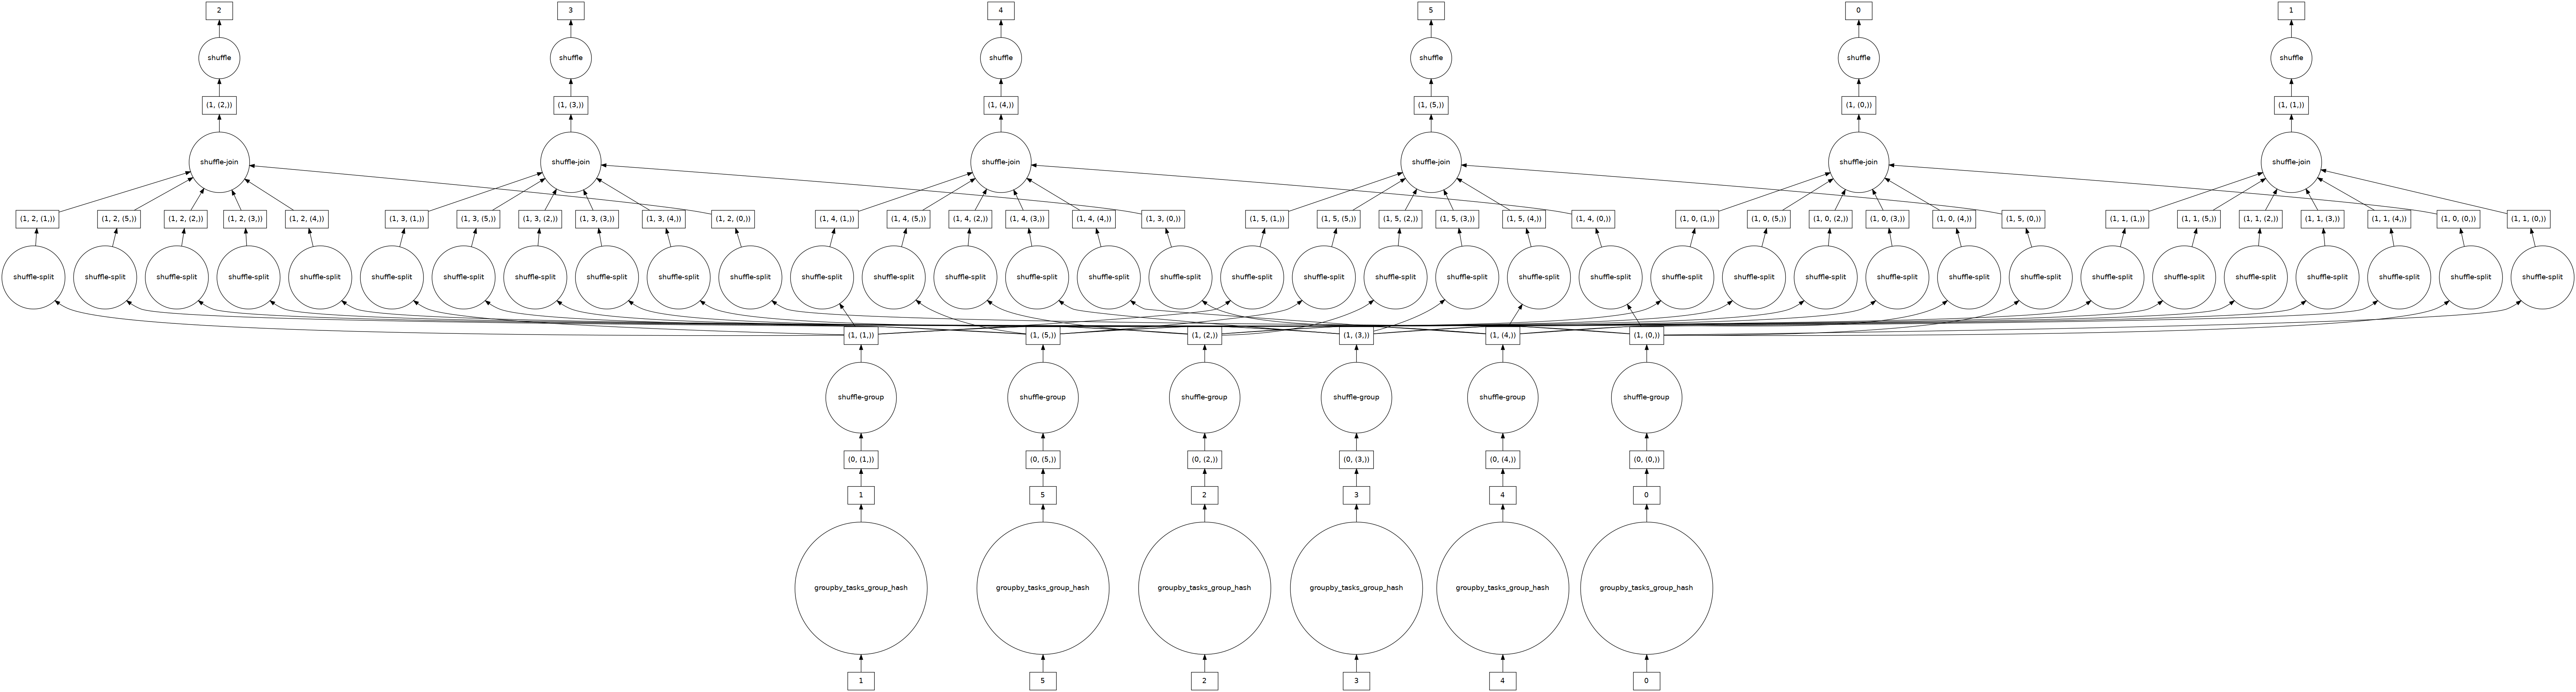

In [21]:
names_data = ['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank']

# create a bag from the list of names
b = db.from_sequence(names_data)

# group names by length
res = b.groupby(len) 

# visualize this "simple" graph before computing the results
res.visualize()

In [22]:
# compute the results
res.compute()

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

Notice that the result of the `groupby` operation is a tuple. If we need to apply functions to the elements of these tuples, we can use `starmap`.

The `starmap` function in Dask allows us to apply a function using argument tuples, similar to what the standard `itertools.starmap` does in Python.

For example:

In [23]:
# create a simple bag from a list of integers
b = db.from_sequence(list(range(10)))

# group numbers into even/odd groups
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

In [24]:
# return the max value for all elements in each group
b.groupby(lambda x: x % 2)\
 .starmap(lambda k, v: (k, max(v)))\
 .compute()

[(0, 8), (1, 9)]

In [25]:
# return the sum of the elements in each group
b.groupby(lambda x: x % 2)\
 .starmap(lambda k, v: (k, sum(v)))\
 .compute()

[(0, 20), (1, 25)]

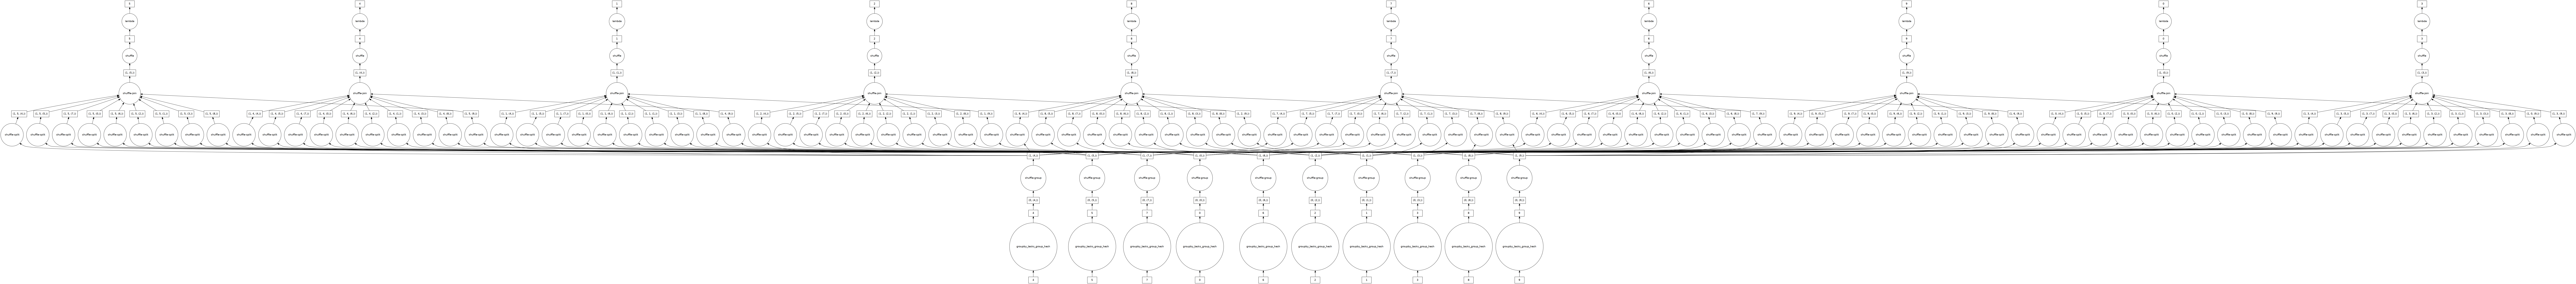

In [26]:
# visualize the graph of this latest "extremely simple" computation
res = b.groupby(lambda x: x % 2)\
       .starmap(lambda k, v: (k, sum(v)))

res.visualize()

`foldby` can seem quite peculiar at first, but it is similar to the following functions in other libraries:

- [`toolz.reduceby`](http://toolz.readthedocs.io/en/latest/streaming-analytics.html#streaming-split-apply-combine)
- [`pyspark.RDD.combineByKey`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.combineByKey.html)

When using `foldby`, you need to provide:

1. A **key function to group elements** (similar to `groupby`)
2. A **binary operator** (function that takes 2 elements and return 1 of the same type) that performs **reduction within each group**
3. A **combine binary operator** that can **combine the results of two `reduce` calls on different parts of your dataset**

In Dask, a `foldby` call like this:
```python
dask_bag.foldby(key, binop, init)
```

is equivalent to a combination of two operations: groupby and reduce:

```python
def reduction(group):
    return reduce(binop, group, init)

dask_bag.groupby(key).map(lambda (k, v): (k, reduction(v)))
```

The reduction operation must be associative, and it is executed in parallel within each partition of the dataset. The intermediate results are then combined using the `combine` binary operator.

Let's re-write the equivalent group-by + starmap operation with a foldby call

```python
b.groupby(lambda x: x % 2)\
 .starmap(lambda k, v: (k, sum(v)))\
 .compute()
```

In [27]:
# create a simple bag from a list of integers
b = db.from_sequence(list(range(10)))

In [28]:
# groupby even/odd numbers with a foldby and find the total sum per group
#
#   write down a **binary filter function** to select only even or odd numbers
#   write down a **reduce-like operation** to sum all elements
is_even = lambda x: x % 2 == 0 
add     = lambda x, y: x + y
b.foldby(key=is_even, 
         binop=add, 
         initial=0).compute()

[(True, 20), (False, 25)]

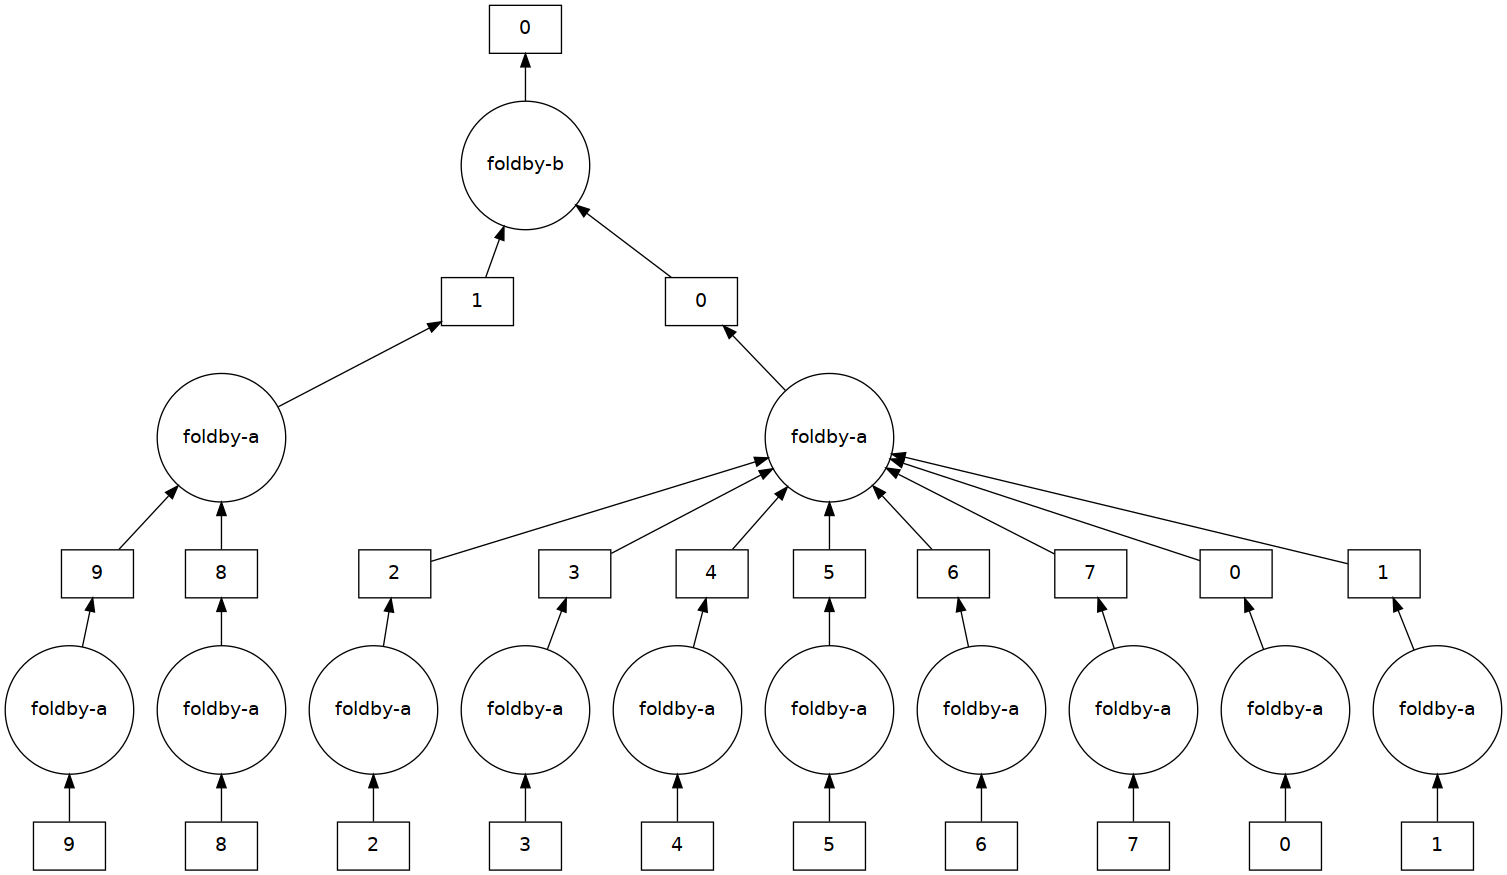

In [29]:
# have a look at the graph and compare it 
# with the groupby implementation
# 
# the `split_every` option instructs foldby to group 
# partitions into groups of this size while performing the reduction.
# (`split_every` defaults to 8)
b.foldby(is_even, 
         add, 
         initial=0, 
         split_every=8).visualize()

## Exercise 2 - Account data

Take a moment to look to the `foldby` API at the [link](https://docs.dask.org/en/latest/generated/dask.bag.Bag.foldby.html#dask.bag.Bag.foldby).

- Get the total number of users with the same name from the account dataset
  1. Use a `groupby` function and measure the required computational time
  2. Use a `foldby` function and measure the required computational time

In [30]:
%%time
# groupby on the 'name' key 
# count the number of items in each group
result_groupby = db_js.groupby(lambda item: item["name"]).starmap(lambda k, v: (k, len(v))).compute()

CPU times: user 77.6 ms, sys: 15.6 ms, total: 93.1 ms
Wall time: 44.7 s


Let's inspect what `groupby` is doing in Dask...

In [33]:
sorted(result_groupby)[:10]

[('Alice', 464),
 ('Alice', 464),
 ('Alice', 522),
 ('Bob', 321),
 ('Bob', 564),
 ('Charlie', 259),
 ('Charlie', 550),
 ('Dan', 208),
 ('Dan', 208),
 ('Dan', 234)]

**Wait a second...!**

What about `foldby` then?

In [35]:
%%time
# foldby on 'name' key 
# increment by one each time we see an element (binop function)
# use a final combination function with add (combine function)
result_foldby = db_js.foldby(key="name", 
                            binop=lambda x, _: x+1, 
                            initial=0, 
                            combine=add, 
                            combine_initial=0).compute()

CPU times: user 28.1 ms, sys: 0 ns, total: 28.1 ms
Wall time: 2.89 s


In [36]:
sorted(result_foldby)

[('Alice', 1450),
 ('Bob', 885),
 ('Charlie', 809),
 ('Dan', 650),
 ('Edith', 1200),
 ('Frank', 900),
 ('George', 750),
 ('Hannah', 1100),
 ('Ingrid', 999),
 ('Jerry', 1089),
 ('Kevin', 1144),
 ('Laura', 700),
 ('Michael', 1298),
 ('Norbert', 791),
 ('Oliver', 1190),
 ('Patricia', 850),
 ('Quinn', 800),
 ('Ray', 755),
 ('Sarah', 1050),
 ('Tim', 899),
 ('Ursula', 993),
 ('Victor', 1000),
 ('Wendy', 808),
 ('Xavier', 750),
 ('Yvonne', 750),
 ('Zelda', 1144)]

Dask may exhibit unexpected behavior when using the `groupby` function with string keys instead of numerical features. In some cases, it may return a group count per partition instead of a single group count per key.

This issue highlights a couple of factors:
1. Dask is a relatively new framework and is still being actively developed.
2. Distributed computing, especially when dealing with complex operations like grouping, can be challenging to implement correctly and efficiently.
3. In Dask, the `foldby` function is often preferred over `groupby` as it provides more control and efficiency in the grouping and reduction process.

If you encounter issues with `groupby` and string keys, it is recommended to consider alternative approaches or use `foldby` for more reliable results.

## Exercise 3 - Still on account data

Let's compute the total transfers amount per each name using a foldby operation.

We can proceed in two steps:
1.  Create a function that takes an input dictionary, such as:
    ```python
        {'name': 'Alice', 'transactions': [{'amount': 1, 'id': 123}, {'amount': 2, 'id': 456}]}
    ``` 
    and produces the sum of the amounts. For example, in this case, the sum would be 3.
    
2.  Modify the binary operator of the `foldby` examples above so that it accumulates the sum of the transferred amounts instead of counting the number of entries.

In [ ]:
# add the sum_transactions values together
def add_values(tot, _):
    return 

# compute the sum of transaction amounts per name
def sum_amount(d):    
    return 

# apply sum_amount function to each item in db_js
# perform foldby operation on 'name' key to accumulate the sum of transactions for each name
result_foldby = db_js.

In [ ]:
result_foldby.visualize()

In [ ]:
%%time
result_foldby = result_foldby.compute()

In [ ]:
sorted(result_foldby)

## From Bag to pre-processed output datasets

Dask Bags are often used as an entry point to ingest, decode, and preprocess data before further processing or analysis. Once the data has been processed and transformed, it is often desirable to convert the Dask Bag into a structured data format, such as a Dask DataFrame, for easier manipulation and analysis.

Dask provides several methods to convert Bags into output data objects, including text files, JSON files, and more.
You can refer to the documentation at the [link](https://docs.dask.org/en/stable/bag-creation.html#store-dask-bags) to learn more about these methods:
- `to_textfiles`: writes the Bag data to multiple text files.
- `to_avro`: writes the Bag data to Avro files.
- `to_delayed`: converts the Bag into a list of delayed objects.

By far the most widely used approach in data pre-processing using Dask Bags is to `extract` some raw data from the original input source, `transform` it applying some funcions to filter/reduce/create features from the original (usually messy) dataset, and finally `load` the clensed dataset into either a DataBase or a further data processing pipeline based on *structured* data.

Converting a Dask Bag to a Dask Dataframe is thus a very common operation (very similar to the conversion from RDD to a Spark DataFrame).

To convert a Dask Bag into a Dask DataFrame, the dataset needs to be flattened and normalized before invoking the `to_dataframe` function on the Bag. This flattening and normalization process ensures that the data is in a structured format that can be easily loaded into a DataFrame.

As a purely illustrative example, our account data is deeply nested and not suitable for being transformed into a table-like DataFrame structure.

Assuming we may want to retain only the first transaction per customer (or alternatively, we might have wanted to retain other features, such as the max-amount transfer, or an aggregated quantity per user, etc), we can flatten the dataset by mapping a dedicated function:

In [ ]:
# print one element of the json bag
pprint( db_js.take(1) )

In [ ]:
# function to flatten the nested structure of the record
# and extract specific fields
def dummy_flatten(record):
    return {
        'id': record['id'],
        'name': record['name'],
        'first_transaction_id': record['transactions'][0]['transaction-id'],
        'first_transaction_amount': record['transactions'][0]['amount']
    }

# apply the dummy_flatten function to each record in db_js
# and take the first element from the resulting Bag
pprint(db_js.map(dummy_flatten).take(1))

In [ ]:
# create a Dask DataFrame from the flattened Bag
dd = db_js.map(dummy_flatten).to_dataframe()

In [ ]:
# the Dask DataFrame is still a Dask distributed object, i.e.:
# 1. it is partitioned by default
# 2. it is lazy
dd

In [ ]:
# showing a number of elements (i.e. issuing the `head` method) 
# will trigger the computation and retrieve the results from the cluster
dd.head(10)

## Stop client

In [ ]:
client.close()

Finally, use `docker compose down` to stop and clear all running containers.